In [1]:
import matplotlib
import matplotlib.pyplot as plt

import IPython.display as ipd

import sys
sys.path.append('hifi-gan/')

import os
import numpy as np
import json
import librosa
import torch
import random

from omegaconf import OmegaConf
from env import AttrDict

from synthesizer import Synthesizer
from datasets import TextMelDataset, text_mel_collate
from models import Generator
from meldataset import MAX_WAV_VALUE

%matplotlib inline

In [2]:
def plot_mel_f0_alignment(mel_source, mel_outputs_postnet, f0s, alignments, figsize=(16, 16)):
    fig, axes = plt.subplots(4, 1, figsize=figsize)
    axes = axes.flatten()
    axes[0].imshow(mel_source, aspect='auto', origin='lower', interpolation='none')
    axes[1].imshow(mel_outputs_postnet, aspect='auto', origin='lower', interpolation='none')
    axes[2].scatter(range(len(f0s)), f0s, alpha=0.5, color='red', marker='.', s=100)
    axes[2].set_xlim(0, len(f0s))
    axes[3].imshow(alignments, aspect='auto', origin='lower', interpolation='none')
    axes[0].set_title("Source Mel")
    axes[1].set_title("Predicted Mel")
    axes[2].set_title("Source pitch contour")
    axes[3].set_title("Source rhythm")
    plt.tight_layout()

## Load models from checkpoint

write down your paths below.

In [3]:
vc_decoder_path = '' # path of vc decoder checkpoint
generator_path = '' # path of hifi-gan checkpoint
config_path = 'hifi-gan/config_v1.json' # path of hifi-gan's configuration

In [4]:
print("Loading Synthesizer's checkpoint...")
net=Synthesizer.load_from_checkpoint(vc_decoder_path).cuda().eval()
net.freeze()

hp =net.hp
print("Complete.")

Loading Synthesizer's checkpoint...
Complete.


In [5]:
with open(config_path) as f:
    data = f.read()

json_config = json.loads(data)
h = AttrDict(json_config)
torch.manual_seed(h.seed)
generator = Generator(h).cuda().eval()

print("Loading Generator's checkpoint...")

state_dict_g = torch.load(generator_path, map_location='cpu')
generator.load_state_dict(state_dict_g['generator'])
generator.remove_weight_norm()

print("Complete.")

Loading Generator's checkpoint...
Removing weight norm...
Complete.


## Load source data

1. Add your custom source audios at datasets/inference_source
2. Add your audio's name and transcript at datasets/inference_source/metadata.txt
3. Change file_idx below and inference with that source audio

In [6]:
targetloader = TextMelDataset(hp, 'datasets/inference_source','metadata_g2p.txt',train=False, use_f0s = True)
dataloader = TextMelDataset(hp, hp.data.train_dir,hp.data.train_meta,train=False, use_f0s = True)

print("length of the source metadata is : ",len(targetloader))

length of the source metadata is :  1


In [7]:
file_idx = 0 # starting from 0

In [8]:
audio_path, text,_ = targetloader.meta[file_idx]
x = targetloader.__getitem__(file_idx)

batch = text_mel_collate([x])

print(text)

{DH EH R} {M EY} {B IY} {S AH M} {R IH Z IH S T AH N S}.


In [9]:
x, sr = librosa.load(os.path.join('datasets/inference_source',audio_path))
ipd.Audio(x, rate=hp.audio.sampling_rate)

## Define Speakers Set

In [10]:
speaker_list = list(hp.data.speakers)
print(speaker_list)

['7078', '8108', 'p250', 'p301', 'p274', '3486', 'p267', '5808', 'p361', '7447', '1069', '1088', '2136', '5750', 'p283', 'p341', '118', '8051', 'p256', 'p236', '7059', '3436', '7302', 'p336', 'p311', 'p298', 'p259', 'p284', 'p347', '2289', 'p263', 'p326', '4088', 'p225', 'p251', '254', 'p273', 'p374', '4195', 'p226', '4680', 'p246', '3664', '2843', 'p252', '1116', '6209', 'p297', '7226', 'p300', 'p307', '8312', '6019', '7367', '2196', 'p233', '3983', '1263', 'p247', 'p345', '374', '4397', 'p304', 'p255', '460', '587', 'p318', '1502', '8123', '8098', 'p249', '4362', 'p333', '5703', 'p305', '4406', 'p316', '7190', 'p295', 'p241', 'p281', '4267', '3242', '696', '7178', '8088', 'p310', '83', '7794', 'p232', 'p258', 'p306', '4018', '6454', '8609', 'p264', 'p312', '6818', 'p279', '1970', 'p265', '1246', 'p288', '6181', 'p238', 'p302', '4051', '7067', '78', '2182', 'p244', 'p269', '6437', '730', 'p227', '6415', 'p285', '6385', '2911', '4788', '4297', 'p339', '5393', '5339', '3857', '405', 'p2

In [11]:
with open('f0s.txt', 'r', encoding='utf-8') as g:
    pitches = g.readlines()
speaker_list_2 = [x.split('|')[0].strip() for x in pitches]
means = [float(x.split('|')[1].strip()) for x in pitches]
variences = [float(x.split('|')[2].strip()) for x in pitches]
if(speaker_list == speaker_list_2):
    print('ok')
else:
    print('error')

ok


# Style Transfer (Rhythm and Pitch Contour)

In [12]:
file_idx = random.randrange(len(dataloader))
audio_path, _,_ = dataloader.meta[file_idx]
x = dataloader.__getitem__(file_idx)
target_batch = text_mel_collate([x])
x, sr = librosa.load(os.path.join(hp.data.val_dir,audio_path))
ipd.Audio(x, rate=hp.audio.sampling_rate)

In [13]:
with torch.no_grad():
    text, mel_source, speakers, f0_padded, input_lengths, output_lengths, max_input_len, _ = batch
    _, mel_reference, _,_,_,_,_, _ = target_batch

In [14]:
    text=text.cuda()
    mel_source = mel_source.cuda()
    mel_reference = mel_reference.cuda()
    f0_padded = f0_padded.cuda()
    mel_predicted, alignment, residual = net.inference(text, mel_source, mel_reference, f0_padded)
    print(text)

tensor([[104,  74,  75,  92,  64,  86,  77,  64,  71,  82,  64,  93,  67,  86,
          64,  92,  81, 102,  81,  93,  95,  67,  87,  93,  60,   1]],
       device='cuda:0')


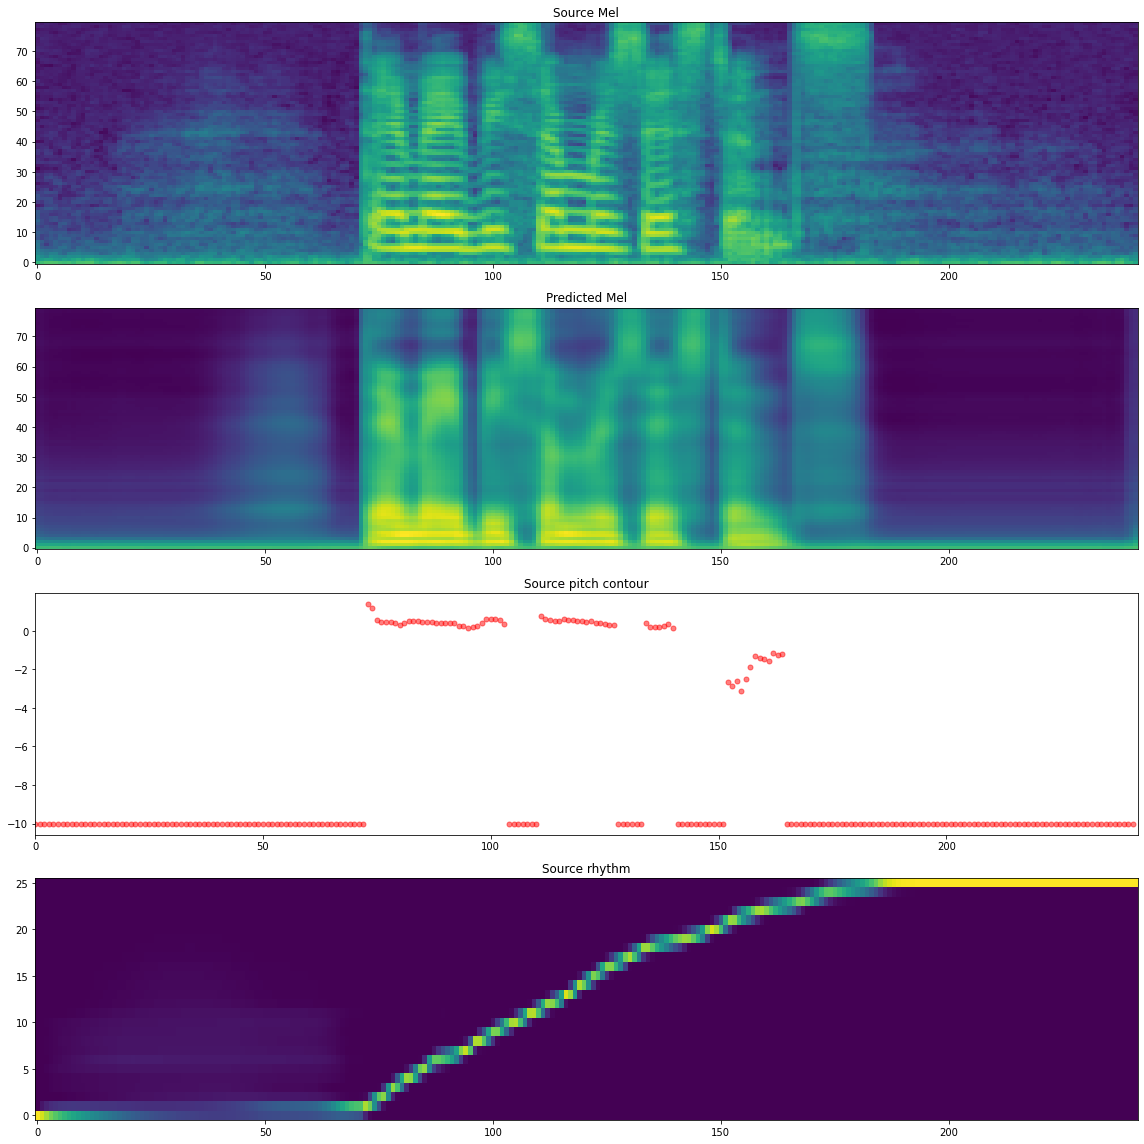

In [15]:
with torch.no_grad():       
    plot_mel_f0_alignment(mel_source.data.cpu().numpy()[0],
                          mel_predicted.data.cpu().numpy()[0],
                          f0_padded.cpu().numpy()[0, 0],
                          alignment.data.cpu().numpy()[0].T)

# Convert spectrogram to audio using vocoder

In [16]:
y_g_hat = generator(mel_predicted)
audio = y_g_hat.squeeze()
audio = audio * MAX_WAV_VALUE
audio = audio.detach().cpu().numpy().astype('int16')

In [17]:
ipd.Audio(audio, rate=hp.audio.sampling_rate)

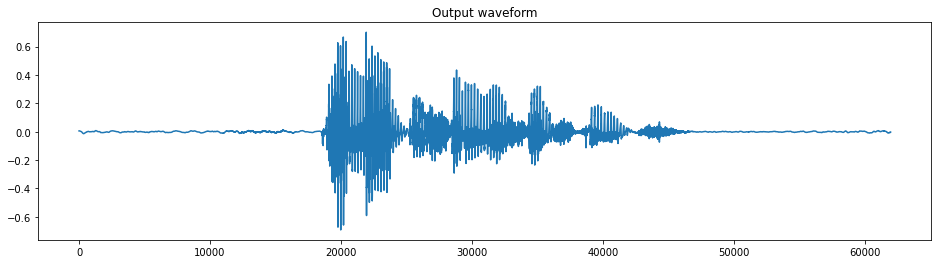

In [18]:
plt.figure(figsize=(16,4))
plt.title("Output waveform")
plt.plot(audio / MAX_WAV_VALUE)
plt.show()